## A practical guide to MCMC 
### Andy Connolly (University of Washington) - ajc@astro.washington.edu
 
### The objectives of this lecture
- **A gentle (re)introduction to MCMC (from a mathematical and intuative perspective)**
- An overview of probablistic programming
- Hands on exercises using PYMC3 (from fitting a distribution to fitting data of increasing complex likelihoods)

### What is the rationale behind Bayesian approaches

Foundational: Breeding a statistician with a clergyman to produce the much sought honest statistician

Bayesian statistics: Only a Bayesian Statistician is able to coherently explain the statement: If there is a 50-50 chance that something can go wrong, then 9 times out of ten it will


<center><img src="figures/marg.png" alt="marg" style="width:600px;"/></center>



### For additional reading

These lectures have been adapted from a range of different materials including
- [A Practical Python Guide for the Analysis of Survey Data](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- Thomas Wiecki: [``MCMC sampling for dummies"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
- [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb) by Cam Davidson Pilon
- Abraham Flaxman's (UW) [discussion of MCMC](https://healthyalgorithms.com/)
- [Astro 324 special topics](https://github.com/uw-astr-324-s17/astr-324-s17)course at the University of Washington

### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

### Software needed

I will assume that you have numpy, scipy, matplotlib installed

For the examples we will be using PYMC3 

- pip install git+https://github.com/pymc-devs/pymc3

To demonstrate how MCMC techniques sample we will use Jake Vanderplas's animation code
- pip install JSAnimation

Aside: PYMC3 should install Theano (a deep learning package) by default as it is used in many of the definitions of distributions. We will call Theano a couple of times in the later exercises

### Testing it all works 

If you want to ensure that you have everything in place try to run the following piece of code (we will walk through what these lines mean as we go through the class). You should see something like the following figure

<center><img src="figures/pymc3-gaussian.png" alt="pymc3 test" style="width:600px;"/></center>


### Exercise 1: What do you know about MCMC and how have you used it in the past

Run the two notebook cells below to make sure that everything is up and running and while you are running the code discuss what you know about MCMC and ways in which you have used it

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy
import scipy.stats as stats 

#from JSAnimation import IPython_display
import pymc3 as pm
import theano as thea
import theano.tensor as T 
%matplotlib inline

Optimization terminated successfully.
         Current function value: 436.802224
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 10000/10000 [00:10<00:00, 1352.05it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a8cb68fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4a8ca61908>]], dtype=object)

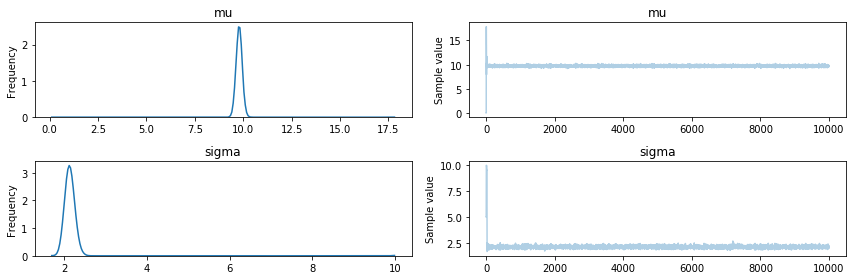

In [10]:
#generate a set of data
N = 200
mu_0 = 10.
sigma_0 = 2.
y = np.random.normal(loc=mu_0, scale=sigma_0, size=N)

#run MCMC
nsamples = 10000
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=-20, upper=20)     # a simple uniform prior
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    y_obs = pm.Normal('Y_obs', mu, sigma, observed=y) # we use the canned distributions in PYMC3
   
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    
    trace = pm.sample(nsamples, step, start, random_seed=123, progressbar=True)
#plot the trace
pm.traceplot(trace)

## Bayesian Statistical Inference

As you have seen in the earlier lectures (and will likely see many times again) in Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that the ** evidence** $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 

 
 ### Estimating $p(\theta)$
 
We want to estimate $p(\theta)$ given data, a likelihood, and priors. For the simplest (low dimensional) case we could simply undertake a grid search to evaluate $p(\theta)$ for all $\theta$. As you might expect this becomes quite slow for large dimensional data sets or for large samples. 

Once we have the posterior we wish to evaluate the multidimensional integral

$$I(\theta) = \int g(\theta) p(\theta) \, d\theta$$

**Why?**

Three examples of this are:

- Marginalization:  if $P$ elements of $\theta$ are the model parameters, and the next $k-P$ parameters are nuisance parameters (often used to capture systematics within the data) we integrate over the space spanned by nuisance parameters $\theta_j$, $j=(P+1), \ldots, k$. For this this case, $g(\theta)=1$. 
- Estimating the posterior mean: $g(\theta)=\theta_m$ and the integral is performed over all other parameters
- Estimating credible regions (interval enclosing $1-\alpha$ of the posterior probability): we evaluate the integral up to an unknown normalization constant because the posterior pdf can be renormalized to integrate to unity.

### Better(?) ways of estimating $p(\theta)$: Monte Carlo Methods 

We can think of these methods as some form of randomized sampling. Monte Carlo methods have been used prior to computers including [Buffon's needle](https://en.wikipedia.org/wiki/Buffon%27s_needle) (Comte de Buffon) that was proposed as a method for estimating $\pi$

<center><img src="figures/220px-Buffon_needle.png" alt="buffon" style="width:300px;"/></center>

The modern version was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects (studying the distance neutrons traveled through different materials), with von Neumann developing techniques for pseudorandom numbers. The name Monte Carlo was given to the method by Nick Metropolis (inventor of the Metropolis sampler, which evolved into one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm). 

Assume that you can generate a distribution of M random numbers $\theta_j$ uniformly sampled within an integration volume V. Then our interval can be evaluated as 
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{V}{M} \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$
    
Note that in 1-D we can write a similar expression 
$$ I = \int f(\theta) \, d\theta = \Delta \, \sum_{j=1}^M f(\theta_j).$$

where $ f(\theta) = g(\theta) \, p(\theta) $, and it is assumed that the values
$\theta_j$ are sampled on a regular grid with the step $\Delta = V/M$ ($V$ here is the
length of the sampling domain). This expression is the simplest example of
numerical integration ("rectangle rule", which amounts to approximating $f(\theta)$
by a piecewise constant function).

The reason why we expressed $f(\theta)$
as a product of $g(\theta)$ and $p(\theta)$ is that, as we will see shortly,
we can generate a sample drawn from $p(\theta)$ (instead of sampling on a 
regular grid), and this greatly improves the performance of numerical integration.

One of the simplest numerical integration methods is generic Monte Carlo. We generate a random set of  M values  $\theta$,  uniformly sampled within the integration volume  $V(\theta)$ as ${ I \approx { V\theta \over M} \sum{j=1}^M g(\theta_j) \, p(\theta_j). }$ This method is very inefficient when the integrated function greatly varies within the integration volume, as is the case for the posterior pdf. This problem is especially acute with high-dimensional integrals.

fractional integration error for pi:
M:  10 0.0185916357881
M:  100 0.0323379460013
M:  1000 0.00178019692763


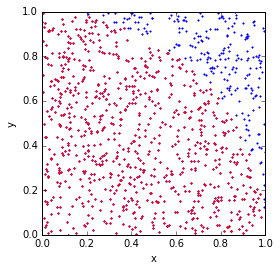

In [3]:
print ("fractional integration error for pi:")
for M in [10, 100, 1000]:
    x = stats.uniform(0, 1).rvs(M)
    y = stats.uniform(0, 1).rvs(M)
    
    r2 = x*x+y*y
    print ('M: ', M, np.abs((np.pi-4.0*np.size(x[r2<1])/M)/np.pi))

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
plt.plot(x, y, '.k', markersize=3, c='blue')
plt.plot(x[r2<1], y[r2<1], '.k', markersize=3, c='red')
ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Exercise 2: Extend this technique to >2 dimensions

Estimate how many samples would be required to reach a 1% estimate of $\pi$ (for the adventurous see Chapter 7 in "A Practical Python Guide for the Analysis of Survey Data" for formula for an n-dimensional hypersphere)


In [29]:
print ("fractional integration error for pi:")
for M in [10, 100, 1000, 10000, 100000]:
    x = stats.uniform(0, 1).rvs(M)
    y = stats.uniform(0, 1).rvs(M)
    z = stats.uniform(0, 1).rvs(M)
    
    r2 = z*z+x*x+y*y
    
    print ('M: ', M, np.abs((np.pi-8.0*np.size(x[r2<1])/M)/np.pi))

#fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
#plt.plot(x, y, '.k', markersize=3, c='blue')
#plt.plot(x[r2<1], y[r2<1], '.k', markersize=3, c='red')
#ax.axis([0, 1, 0, 1], aspect='equal');
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

fractional integration error for pi:
M:  10 0.782535362629
M:  100 0.00687315510657
M:  1000 0.331808563793
M:  10000 0.354472227689
M:  100000 0.336315831781


##  Markov Chains

A number of methods exist that are much more efficient than generic Monte Carlo integration. 
The most popular group of techniques is known as Markov chain Monte Carlo (MCMC) . 

MCMC returns a sample of points, or **chain**, from the k-dimensional parameter space, with 
a distribution that is **asymptotically proportional** to $p(\theta)$. The constant of 
proportionality is not important in the first class of problems we will look at. In model 
comparison problems, the proportionality constant must be known and we will return to this 
point later.

Given such a chain of length M, the integral can be estimated as
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{j=1}^M g(\theta_j).$$

Again, here **the values of $\theta$ are not sampled uniformly from the volume**;
they are sampled **proportionally** to $p(\theta)$! Note that there is no $p(\theta_j)$ 
term next to $g(\theta_j)$ because the proper weighting in the sum is taken care of 
by the sample itself! 

### What is a Markov process or chain?

A Markov process is defined as a sequence of random variables where a parameter depends 
*only* on the preceding value.  Such processes are "memoryless".  
 
Mathematically, we have
$$p(\theta_{i+1}|\{\theta_i\}) = p(\theta_{i+1}|\,\theta_i).$$


Think of $\theta$ as a vector in multidimensional space, and a realization of the chain represents a path through this space. 

For  equilibrium, or a stationary distribution of positions, it is necessary that the transition probability is symmetric:
$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$


This is called the detailed balance or reversibility condition (i.e. the probability of a jump between two points does not depend on the direction of the jump).

The use of resulting chains to perform Monte Carlo integration is called *Markov Chain Monte Carlo* (MCMC).

Given such a chain of length $M$, the integral can be estimated as
$
               I = {1 \over M} \sum_{j=1}^M g(\theta_j).
$
As a simple example, to estimate the expectation value for $\theta_1$ (i.e., $g(\theta)=\theta_1$),
we simply take the mean value of all $\theta_1$ in the chain.

Given a Markov chain, quantitative description of the posterior pdf
becomes a density estimation problem. To visualize the posterior pdf
for parameter $\theta_1$, marginalized over all other parameters, $\theta_2, \ldots, \theta_k$,
we can construct a histogram of all $\theta_1$ values in the chain, and normalize its integral
to 1. To get a MAP (maximum a posterori) estimate for $\theta_1$, we  find the maximum of this marginalized pdf.

In order for a Markov chain to reach a stationary distribution proportional to $p(\theta)$,
the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,
$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$
where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the jump kernel or
transition kernel (and it is assumed that we know how to compute $p(\theta_i)$).

This requirement will be satisfied when the transition probability satisfies the detailed
balance condition
$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$



##  Markov Chain Monte Carlo

*Various MCMC algorithms differ in their choice of transition kernel*

The most classic approach is the **The Metropolis-Hastings algorithm** 

**The Metropolis-Hastings algorithm** adopts acceptance probability
$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$
where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $K(\theta_{i+1}\,|\,\theta_i)$. A Gaussian distribution centered on 
$\theta_i$ is often used for $K(\theta_{i+1}|\theta_i)$.

The original Metropolis algorithm is based on a symmetric proposal distribution,
$K(\theta_{i+1}|\theta_i) =  K(\theta_i|\theta_{i+1})$, which then cancels out from
the acceptance probability. **In this case, $\theta_{i+1}$ is always accepted if
$p(\theta_{i+1}) > p(\theta_i)$, and if not, then it is accepted with a probability
$p(\theta_{i+1})/p(\theta_i)$.**

** When $\theta_{i+1}$ is rejected, $\theta_i$ is added to the chain instead. **



**The key aspect** is that

$\frac{p(M,\theta_{i+1} \,|\,D,I)}{p(M,\theta_{i} \,|\,D,I)} = \frac{\frac{p(D\,|\,M,\theta_{i+1},I)\,p(M,\theta_{i+1},|\,I)}{p(D\,|\,I)}}{\frac{p(D\,|\,M,\theta_i,I)\,p(M,\theta_i\,|\,I)}{p(D\,|\,I)}} = \frac{p(D\,|\,M,\theta_{i+1},I)\,p(M,\theta_{i+1},|\,I)}{p(D\,|\,M,\theta_i,I)\,p(M,\theta_i\,|\,I)}
$

so there is no dependence on the evidence.

This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

##  Markov Chain Monte Carlo

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1) given $\theta_i$ and $K(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 

2) compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.

3) draw a random number between 0 and 1 from a uniform distribution; if it smaller than
   $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$.
   
4) if $\theta_{i+1}$ is accepted added it to the chain, if not, add $\theta_{i}$ to the chain.

5) use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is
  an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for 
  $\theta$ can be computed from 
  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{j=1}^M \theta_j.$$

where M is the number of elements in the chain (e.g. 
the expectation value for $\theta$ is simply the mean value of chain elements). 
  
  

## Caveats

Although $K(\theta_{i+1}|\theta_i)$ satisfies a Markov chain requirement that it
must be a function of only the current position $\theta_i$, it takes a number
of steps to reach a stationary distribution from an initial arbitrary position $\theta_0$.
**These early steps are called the "burn-in" and need to be discarded in analysis.**
There is no general theory for finding transition from the burn-in phase to
the stationary phase; several methods are used in practice. Gelman and Rubin
proposed to generate a number of chains and then compare the ratio of
the variance between the chains to the mean variance within the chains (this
ratio is known as the $R$ statistic). For stationary chains, this ratio will
be close to 1.  

When the posterior pdf is multimodal, the simple Metropolis--Hastings algorithm can
become stuck in a local mode and not find the globally best mode within a reasonable
running time. There are a number of better algorithms, such as Gibbs sampling, parallel
tempering, various genetic algorithms, and nested sampling.

### How do we choose the next step

How far should we step (small steps in parameter space or large). This impacts the efficiency of the process but not if we will reach equilibrium.

We want our samples to be independent of one another which we can determine with the autocorrelation function - we can then adjust the step size to account for this (e.g. ensure that we reject 50% of the proposed steps)

Other techniques: **NUTS (No-U-Turn Sampler)**, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis

[NUTS](http://arxiv.org/abs/1507.08050) is generally the sampler of choice for continuous parameters (it uses  the gradient of the log posterior-density). See the end of this notebook for animations of different strategies 


In [2]:
from IPython.display import HTML
HTML('<iframe src="https://player.vimeo.com/video/19274900" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274900">Metropolis in the Square</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')


In [3]:
HTML('<iframe src="https://player.vimeo.com/video/19274173" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274173">Metropolis in Diagonal Region</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')